# ML Project: Reddit Activity and Performance of Stock Prices

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from analysis_auxiliary import (
    add_word_counter,
    analyze_sentiment,
    create_date_cols_reddit_data,
    create_date_cols_stock_data,
    merge_reddit_and_stock_data,
    plot,
)

# Prepare Data

In [2]:
# Load wallstreetbets data
wsb_sep_jan = pd.read_csv("data/wsb_sep_01_jan_30.csv")
wsb_jan_feb = pd.read_csv("data/wsb_jan_31_feb_20.csv")
wsb_feb = pd.read_csv("data/wsb_feb_20_feb_28.csv")
wsb = pd.concat([wsb_sep_jan, wsb_jan_feb, wsb_feb])
wsb = create_date_cols_reddit_data(wsb, "date")

wsb_GME = add_word_counter(
    wsb, text_col="title", buzz_words=["GME", "Gamestop"], counter_col="GME_counts", case_sensitive=False
)
wsb_AMC = add_word_counter(
    wsb, text_col="title", buzz_words=["AMC", "Gamestop"], counter_col="AMC_counts", case_sensitive=False
)
wsb_BB = add_word_counter(
    wsb, text_col="title", buzz_words=["BB", "BlackBerry", "Black Berry"], counter_col="BB_counts", case_sensitive=False
)

# Load stock data
stock = pd.read_csv("data/memestocks.csv")

# GME
gme = create_date_cols_stock_data(stock, "date", stock_name="GME")

# AMC
amc = create_date_cols_stock_data(stock, "date", stock_name="AMC")

# BB
bb = create_date_cols_stock_data(stock, "date", stock_name="BB")

In [3]:
# Sentiment Analysis
wsb_GME = analyze_sentiment(wsb_GME, "title")
wsb_AMC = analyze_sentiment(wsb_AMC, "title")
wsb_BB = analyze_sentiment(wsb_BB, "title")

In [4]:
# Merge DataFrames
reddit_gme_hourly = merge_reddit_and_stock_data(wsb_GME, gme, "date_hour", "GME_counts")
reddit_gme_daily = merge_reddit_and_stock_data(wsb_GME, gme, "date_day", "GME_counts")

reddit_amc_hourly = merge_reddit_and_stock_data(wsb_AMC, amc, "date_hour", "AMC_counts")
reddit_amc_daily = merge_reddit_and_stock_data(wsb_AMC, amc, "date_day", "AMC_counts")

reddit_bb_hourly = merge_reddit_and_stock_data(wsb_BB, bb, "date_hour", "BB_counts")
reddit_bb_daily = merge_reddit_and_stock_data(wsb_BB, bb, "date_day", "BB_counts")


gme_sentiment_hourly = pd.merge(wsb_GME, gme, how="left", on="date_hour")
gme_sentiment_hourly = gme_sentiment_hourly[
    gme_sentiment_hourly["date_hour"] <= gme["date_hour"].max()
]

amc_sentiment_hourly = pd.merge(wsb_AMC, amc, how="left", on="date_hour")
amc_sentiment_hourly = amc_sentiment_hourly[
    amc_sentiment_hourly["date_hour"] <= amc["date_hour"].max()
]

bb_sentiment_hourly = pd.merge(wsb_BB, bb, how="left", on="date_hour")
bb_sentiment_hourly = bb_sentiment_hourly[
    bb_sentiment_hourly["date_hour"] <= bb["date_hour"].max()
]

## Result 1: Mentions of Stock in *wallstreetbets* Subreddit and Performance of Stock Price

## *GME*

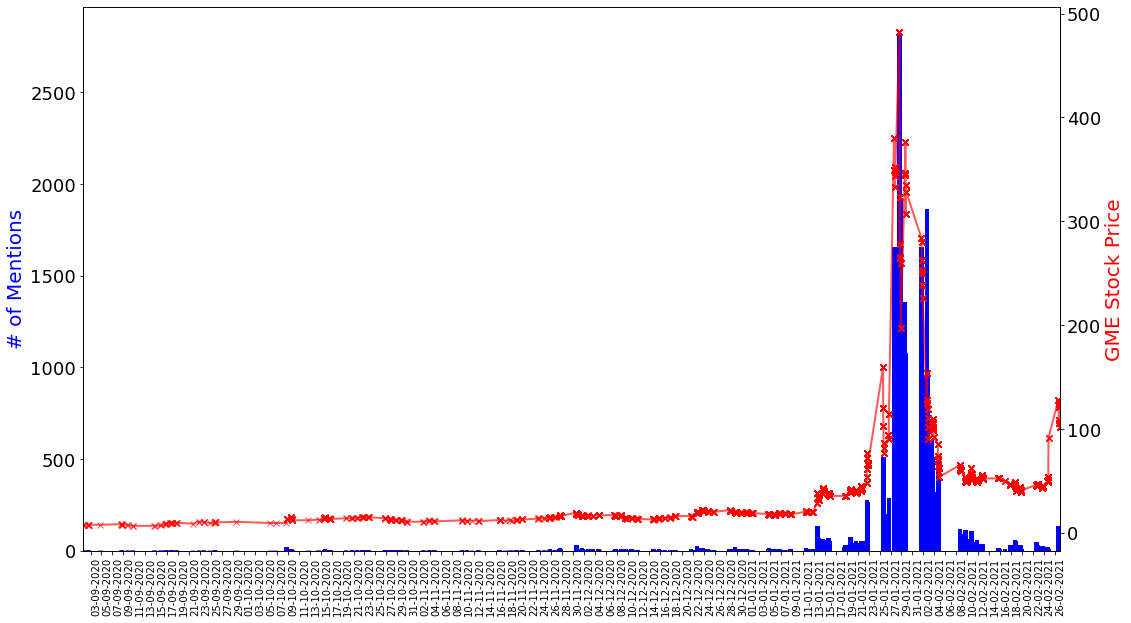

In [5]:
plot(
    reddit_gme_hourly,
    date_col="date_hour",
    count_col="GME_counts",
    stock_price_col="high",
    stock_name="GME",
    save_as="plots/correlation_gme_stock_price.png",
)

## *AMC*

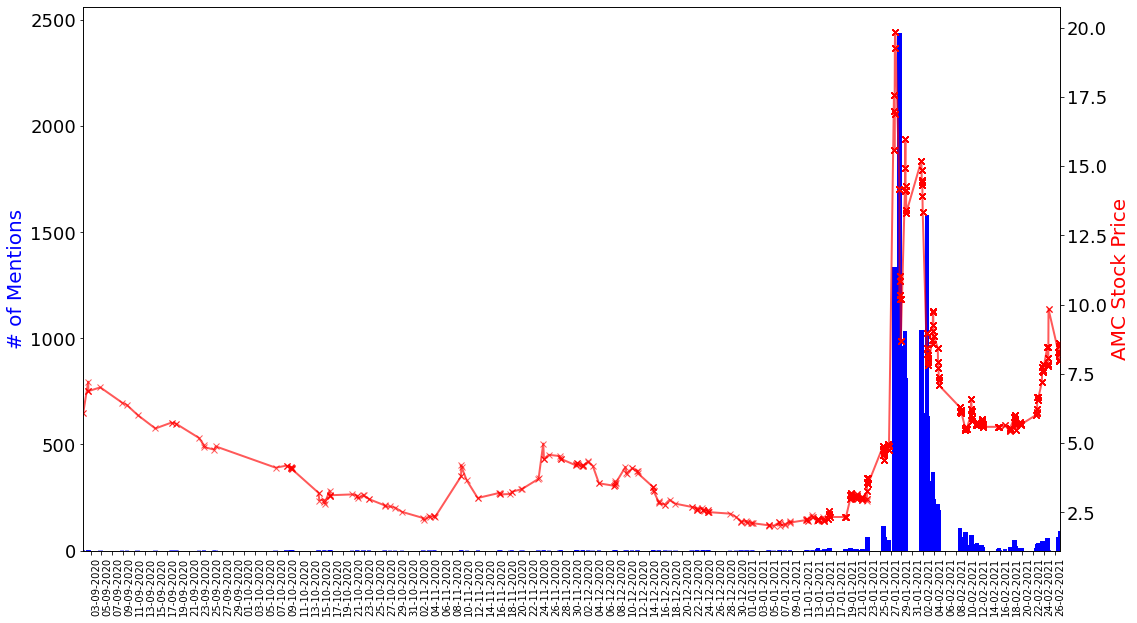

In [6]:
plot(
    reddit_amc_hourly,
    date_col="date_hour",
    count_col="AMC_counts",
    stock_price_col="high",
    stock_name="AMC",
    save_as="plots/correlation_am_stock_price.png",
)

## *BlackBerry*

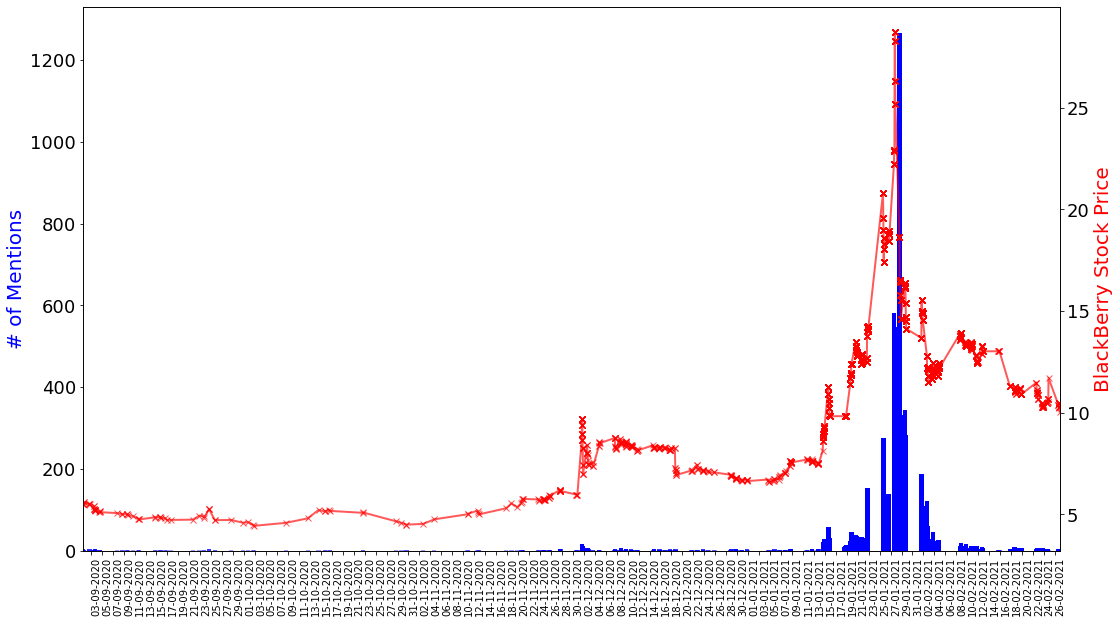

In [7]:
plot(
    reddit_bb_hourly,
    date_col="date_hour",
    count_col="BB_counts",
    stock_price_col="high",
    stock_name="BlackBerry",
    save_as="plots/correlation_bb_stock_price.png",
)

## Result 2: Sentiment Analysis

## *GME*

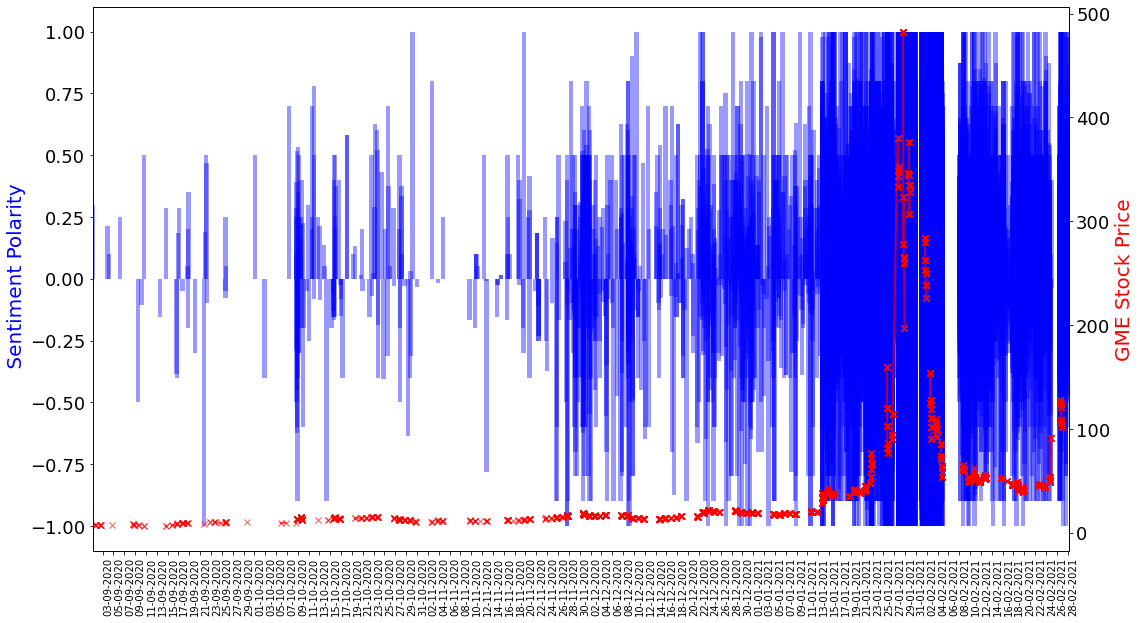

In [8]:
plot(
    gme_sentiment_hourly,
    date_col="date_hour",
    count_col="sentiment_polarity",
    y_label=" Sentiment Polarity",
    stock_price_col="high",
    stock_name="GME",
    save_as="plots/sentiment_polarity_gme_with_stock_price.png",
)

## *AMC*

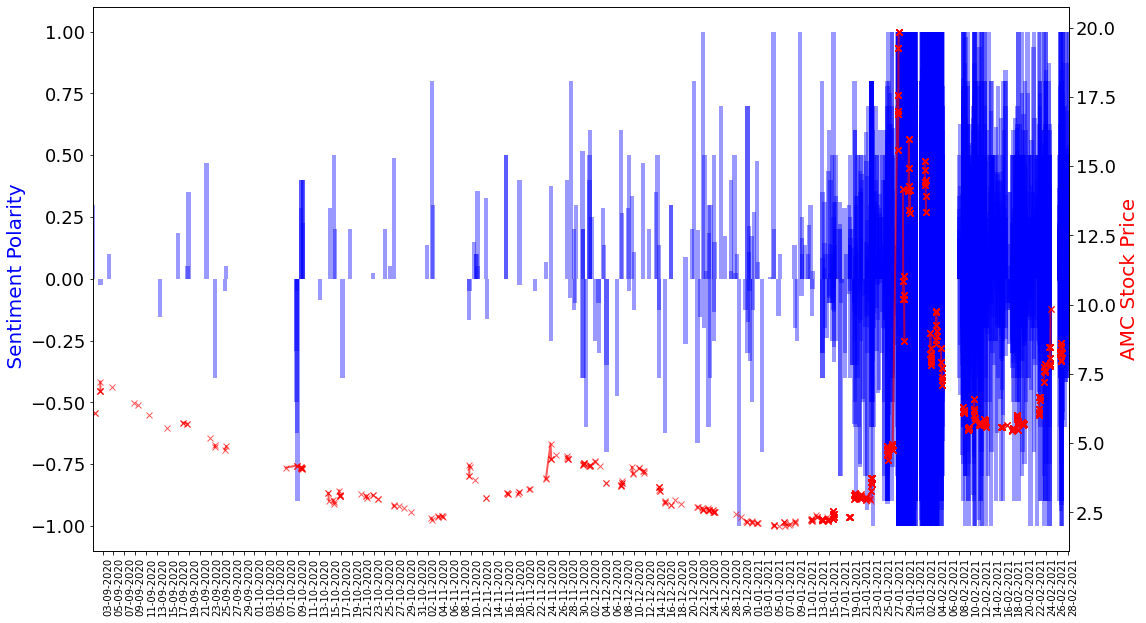

In [9]:
plot(
    amc_sentiment_hourly,
    date_col="date_hour",
    count_col="sentiment_polarity",
    y_label=" Sentiment Polarity",
    stock_price_col="high",
    stock_name="AMC",
    save_as="plots/sentiment_polarity_amc_with_stock_price.png",
)

## *BlackBerry*

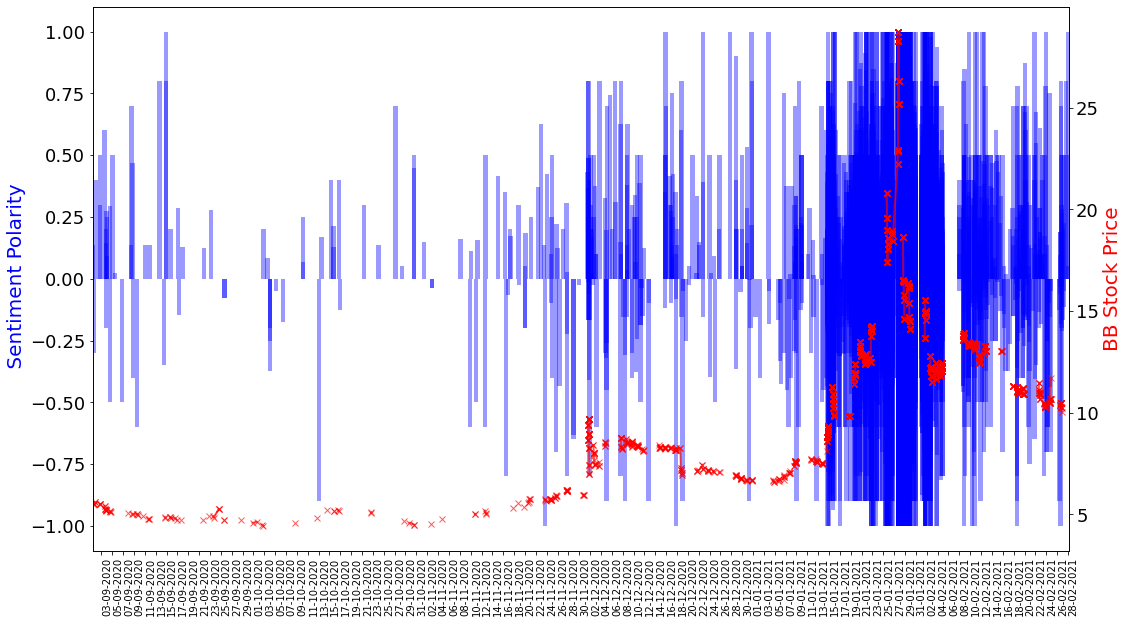

In [10]:
plot(
    bb_sentiment_hourly,
    date_col="date_hour",
    count_col="sentiment_polarity",
    y_label=" Sentiment Polarity",
    stock_price_col="high",
    stock_name="BB",
    save_as="plots/sentiment_polarity_bb_with_stock_price.png",
)

## OLS Regression: Which variables can explain changes in stock price?

## *GME*

In [11]:
y = reddit_gme_hourly["high"]
X = reddit_gme_hourly[
    [
        "GME_counts",
        "upvote_ratio",
        "num_comments",
        "num_crossposts",
        "total_awards_received",
        "no_follow",
        "subreddit_subscribers",
        "stickied",
    ]
]
X = sm.add_constant(X)

In [12]:
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   high   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     7356.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:10:49   Log-Likelihood:            -3.7520e+05
No. Observations:               63484   AIC:                         7.504e+05
Df Residuals:                   63475   BIC:                         7.505e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   165.09

## *AMC*

In [13]:
y = reddit_amc_hourly["high"]
X = reddit_amc_hourly[
    [
        "AMC_counts",
        "upvote_ratio",
        "num_comments",
        "num_crossposts",
        "total_awards_received",
        "no_follow",
        "subreddit_subscribers",
        "stickied",
    ]
]
X = sm.add_constant(X)

In [14]:
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   high   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     1150.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:10:51   Log-Likelihood:            -1.0206e+05
No. Observations:               38294   AIC:                         2.041e+05
Df Residuals:                   38285   BIC:                         2.042e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    20.13

## *BlackBerry*

In [15]:
y = reddit_bb_hourly["high"]
X = reddit_bb_hourly[
    [
        "BB_counts",
        "upvote_ratio",
        "num_comments",
        "num_crossposts",
        "total_awards_received",
        "no_follow",
        "subreddit_subscribers",
        "stickied",
    ]
]
X = sm.add_constant(X)

In [16]:
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   high   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     652.2
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:10:51   Log-Likelihood:                -41911.
No. Observations:               14613   AIC:                         8.384e+04
Df Residuals:                   14604   BIC:                         8.391e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    27.82